In [1]:
!pip install numpy
!pip install matplotlib
!pip install wquantiles
import os
os.chdir('../nfs/Shared/robust_federated_learning/')

In [2]:
from functools import partial
from util.aggregators import mean, median, trimmed_mean, gamma_mean, geometric_median
#from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, IncrementalPCA
import pathlib
import numpy as np
import matplotlib.pyplot as plt

linewidth = 3.0
SMALL_SIZE = 10
MEDIUM_SIZE = 22
BIGGER_SIZE = 30
SUPPER_BIG = 40
plt.rc('font', size=BIGGER_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)      # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)    # fontsize of the figure title

def generate(p, m, gen_par):
  """
  shape (m, p), p:#parameters, m:#machines
  """
  if gen_par["distribution"]=="multi_norm":
    return gen_par["generator"](gen_par["mu"], gen_par["sigma"], m)
  elif gen_par["distribution"]=="t_dist":
    return gen_par["generator"](gen_par["location"], gen_par["shape"], gen_par["df"], m)

#another usage
#not sure which one is more convenient for our simulation
#def generate(p, m, generator, *par):
#  """
#  shape (m, p), p:#parameters, m:#machines
#  """
#  if generator=="multi_norm":
#    return np.random.multivariate_normal(*par, size = m)
#data = generate(p=100, m=20, generator="multi_norm", mu, sigma)

"""
return data should be v1,v2,...
v1,v2,... are np.array
"""

def bias(y_pred, y_true):
    """
    y_pred: (max_ite, p)
    y_true: (p,)
    """
    return np.square(np.subtract(np.mean(y_pred, axis = 0),y_true)).mean()
bias.__name__="bias"

def mse(y_pred, y_true):
    """
    y_pred: (max_ite, p)
    y_true: (p,)
    """
    return np.mean([np.square(np.subtract(y_hat,y_true))  for y_hat in y_pred], axis = 0).mean()
mse.__name__="mse"

def variance(y_pred, y_true):
    """
    y_pred: (max_ite, p)
    y_true: (p,)
    """
    return np.mean([np.square( np.subtract( y_hat, np.mean(y_pred, axis = 0) ) )  for y_hat in y_pred], axis = 0).mean()
variance.__name__="variance"

def compute_result(estimate, truth, metric):
    """
    metric = [bias, mse, ...]
    """
    result = []
    for fn in metric:
        result.append(fn(estimate,truth))
    return np.array(result)

2022-01-12 06:27:49.051742: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
"""
p: dimension
m: machines
b: byz_machines
"""

def Gaussian_gen(mu, sigma):
    return {"distribution": "multi_norm",
          "generator": np.random.multivariate_normal,
          "mu": mu,
          "sigma": sigma 
          } 
        
def t_gen(mu, sigma, df):
    def multivariate_t_rvs(mu, S, df ,size):
        '''generate random variables of multivariate t distribution
        Parameters
        ----------
        mu : array_like
            mean of random variable, length determines dimension of random variable
        S : array_like
            square array of covariance  matrix
        df : int or float
            degrees of freedom
        size : int
            number of observations, return random array will be (size, len(mu))
        Returns
        -------
        rvs : ndarray, (size, len(mu))
            each row is an independent draw of a multivariate t distributed
            random variable
        '''
        mu = np.asarray(mu)
        d = len(mu)
        if df == np.inf:
            x = 1.
        else:
            x = np.random.chisquare(df, size)/df
        z = np.random.multivariate_normal(np.zeros(d),S,(size,))
        return mu + z/np.sqrt(x)[:,None]
    return {"distribution": "t_dist",
          "generator": multivariate_t_rvs,
          "location": mu,
          "shape": sigma,
          "df":df
          }

In [4]:
"""
Scenario 1
multiple experiments 

fix m=200 alpha=0 
data from T distribution(df=3)
when gamma=0.01
get station and low bias/p when p goes to 1000
bias/p about 0.01

data from multi-normal distribution
when gamma=0.01
get station and low bias/p when p goes to 1000
bias/p about 0.005
"""
#set seed
seed = 2021
file_path = pathlib.Path("./plot/scenario1_alpha_0.npz")
m = 200 #Total machines
alpha = 0
b = int(m*alpha) #Byzantine machines
simu_iter = 100 #number of experiments
#gamma = 0.005
beta = 0.1
# p: dimension 
  
t_df = 5 # degree of freedom in t distribution
p_range = np.arange(20,1000,20)
metrics = [mse, bias, variance] #plot as below
"""
  for i, metric in enumerate(metrics):
  plot results[dist][method][i_metrics,:] 
  ylab metric
""" 

dist_list = ["Gaussian", "T_dist"]  #for convenience if one day we want to add more generate dist
#declare a dictionary to map the generators to functions
dist2fun = {"Gaussian":Gaussian_gen, 
            "T_dist":partial(t_gen, df = t_df)
            }

#for convenient if one day we want to add more aggregator
method_list = ["gamma","geo","median","trim","mean"]
labels=['\u03B3-mean with \u03B3=2/p', 'GeoMed', 'marginal median', 'Trimmed-mean with \u03B2 = {}'.format(beta), 'mean']

if file_path.is_file():
  print("load results file")
  results = np.load(file_path, allow_pickle = True,)
  results = results['arr_0'].item()
else:
  #declare a dictionary, it is very convenient to add more object inside
  results=dict()
  #iterate all generators
  for dist in dist_list:
    #to restore results
    temp_result = dict()
    for method in method_list:
      temp_result[method] = np.zeros((len(metrics),len(p_range)))

    for p in p_range:
      mu = [0]*p
      mu_byz = [100]*p
      index = int((p / 20) - 1)
      gamma = 2/p
      #declare a dictionary to map the methods to functions
      method2fun = {"mean":partial(mean, weights = None),
                    "median":partial(median, weights = None),
                    "gamma":partial(gamma_mean, weights = None, compute = '1D', gamma = gamma),
                    "geo":partial(geometric_median, weights = None),
                    "trim":partial(trimmed_mean, weights = None, beta = beta)
                    }
    
      gen_par = dist2fun[dist](mu, sigma=np.eye(p))
      byz_par = dist2fun[dist](mu_byz, sigma=np.eye(p))

      #to restore the estimation
      temp = dict()
      for method in method_list:
        temp[method]=[]
      #iterate many times
      for t in range(simu_iter):
        if int(p/20)==p/20 and int(t/20)==t/20:
          print("Iterate: {} for dimension: {} with data generated from {}".format(t,p,dist))
        np.random.seed(seed + 100*t + p)
        input = np.concatenate((generate(p, m-b, gen_par), generate(p, b, byz_par)), axis = 0) if b>0 else generate(p, m, gen_par)
        for method in method_list:
          temp[ method ].append( method2fun[ method ]( input ) )
        #end repeating simulation for-loop
      for method in method_list:
        temp_result[method][:,index] = compute_result(temp[ method ], mu, metrics)
      #end p_range for-loop
    results [dist] = temp_result
    np.savez(file_path, results)
    #end dist_list for-loop

load results file


/tmp/ipykernel_4056256/3808957622.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


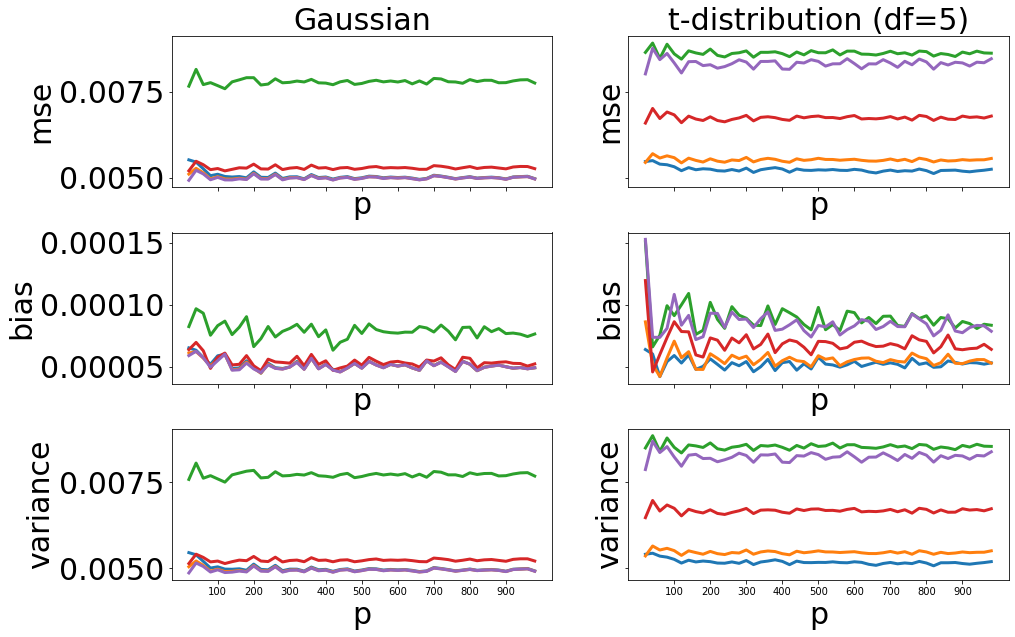

In [5]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs

ax1.set_title("Gaussian")
ax2.set_title('t-distribution (df=5)')
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in method_list:
      r = results[dist][method][i,:]
      ax.plot(p_range, r, label = method, linewidth = linewidth) 
      ax.set_xlabel('p')
      ax.set_xticks(p_range[np.arange(4,len(p_range),5)])
    ax.set_ylabel(metric.__name__)
ax = right[0]
  #method_list is ["mean","median","gamma","geo","trim"] need to use the same order
#ax.legend(labels=labels,
#            loc='upper right',bbox_to_anchor=(2.6,1.0))

fig.tight_layout()
plt.show()

fig.savefig('plot/scenario1_alpha_0.png', format='png', bbox_inches='tight')

In [6]:
"""
Scenario 1
multiple experiments 

fix m=200 alpha=0 
data from T distribution(df=3)
when gamma=0.01
get station and low bias/p when p goes to 1000
bias/p about 0.01

data from multi-normal distribution
when gamma=0.01
get station and low bias/p when p goes to 1000
bias/p about 0.005
"""
#set seed
seed = 2021
file_path = pathlib.Path("plot/scenario1_alpha_0.1.npz")
m = 200 #Total machines
alpha = 0.1
b = int(m*alpha) #Byzantine machines
simu_iter = 100 #number of experiments
#gamma = 0.005
beta = 0.1
# p: dimension 
p_range = np.arange(20,1000,20)
t_df = 5 # degree of freedom in t distribution

metrics = [mse, bias, variance] #plot as below

"""
for i, metric in enumerate(metrics):
  plot results[dist][method][i_metrics,:] 
  ylab metric
""" 

dist_list = ["Gaussian", "T_dist"]  #for convenience if one day we want to add more generate dist
#declare a dictionary to map the generators to functions
dist2fun = {"Gaussian":Gaussian_gen, 
            "T_dist":partial(t_gen, df = t_df)
            }

#for convenient if one day we want to add more aggregator
method_list = ["gamma","geo","median","trim","mean"]
labels=['\u03B3-mean with \u03B3=2/p', 'GeoMed', 'marginal median', 'Trimmed-mean with \u03B2 = {}'.format(beta), 'mean']

if file_path.is_file():
  print("load results file")
  results = np.load(file_path, allow_pickle = True)
  results = results['arr_0'].item()
else:
  #declare a dictionary, it is very convenient to add more object inside
  results=dict()

  #iterate all generators
  for dist in dist_list:
    #to restore results
    temp_result = dict()
    for method in method_list:
      temp_result[method] = np.zeros((len(metrics),len(p_range)))

    for p in p_range:
      mu = [0]*p
      mu_byz = [100]*p
      index = int((p / 20) - 1)
      gamma = 2/p
      #declare a dictionary to map the methods to functions
      method2fun = {"mean":partial(mean, weights = None),
                    "median":partial(median, weights = None),
                    "gamma":partial(gamma_mean, weights = None, compute = '1D', gamma = gamma),
                    "geo":partial(geometric_median, weights = None),
                    "trim":partial(trimmed_mean, weights = None, beta = beta)
                    }
      
      gen_par = dist2fun[dist](mu, sigma=np.eye(p))
      byz_par = dist2fun[dist](mu_byz, sigma=np.eye(p))

      #to restore the estimation
      temp = dict()
      for method in method_list:
        temp[method]=[]
      #iterate many times
      for t in range(simu_iter):
        if int(p/20)==p/20 and int(t/20)==t/20:
          print("Iterate: {} for dimension: {} with data generated from {}".format(t,p,dist))
        np.random.seed(seed + 100*t + p)
        input = np.concatenate((generate(p, m-b, gen_par), generate(p, b, byz_par)), axis = 0) if b>0 else generate(p, m, gen_par)
        for method in method_list:
          temp[ method ].append( method2fun[ method ]( input ) )
        #end repeating simulation for-loop
      for method in method_list:
        temp_result[method][:,index] = compute_result(temp[ method ], mu, metrics)
      #end p_range for-loop
    results [dist] = temp_result
    np.savez(file_path, results)
    #end dist_list for-loop

load results file


/tmp/ipykernel_4056256/2884785197.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


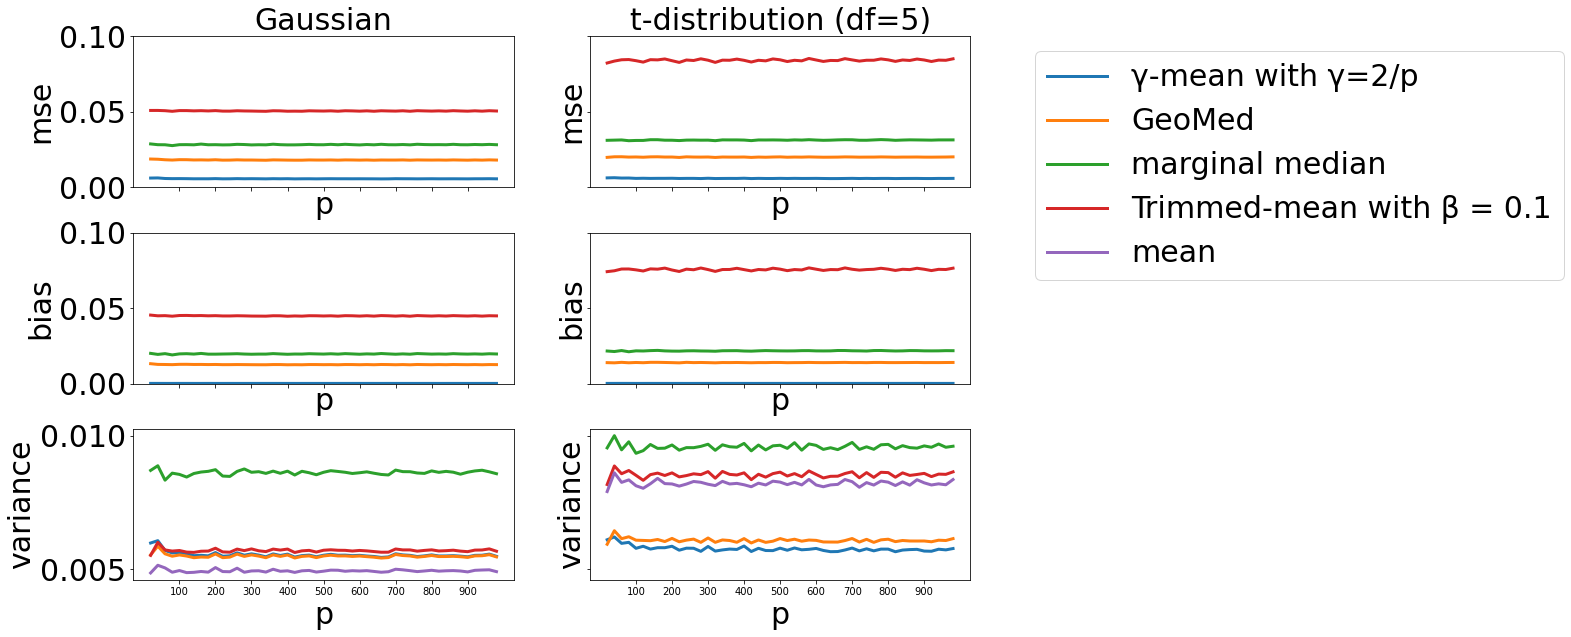

In [7]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs

ax1.set_title("Gaussian")
ax2.set_title('t-distribution (df=5)')
ax1.set_ylim(0,0.1)
ax3.set_ylim(0,0.1)
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in method_list:
      r = results[dist][method][i,:]
      ax.plot(p_range, r, label = method, linewidth = linewidth) 
      ax.set_xlabel('p')
      ax.set_xticks(p_range[np.arange(4,len(p_range),5)])
    ax.set_ylabel(metric.__name__)
ax = right[0]
  #method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=labels,
            loc='upper right',bbox_to_anchor=(2.6,1.0))
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario1_alpha_01.png', format='png', bbox_inches='tight')

/tmp/ipykernel_4056256/41548483.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


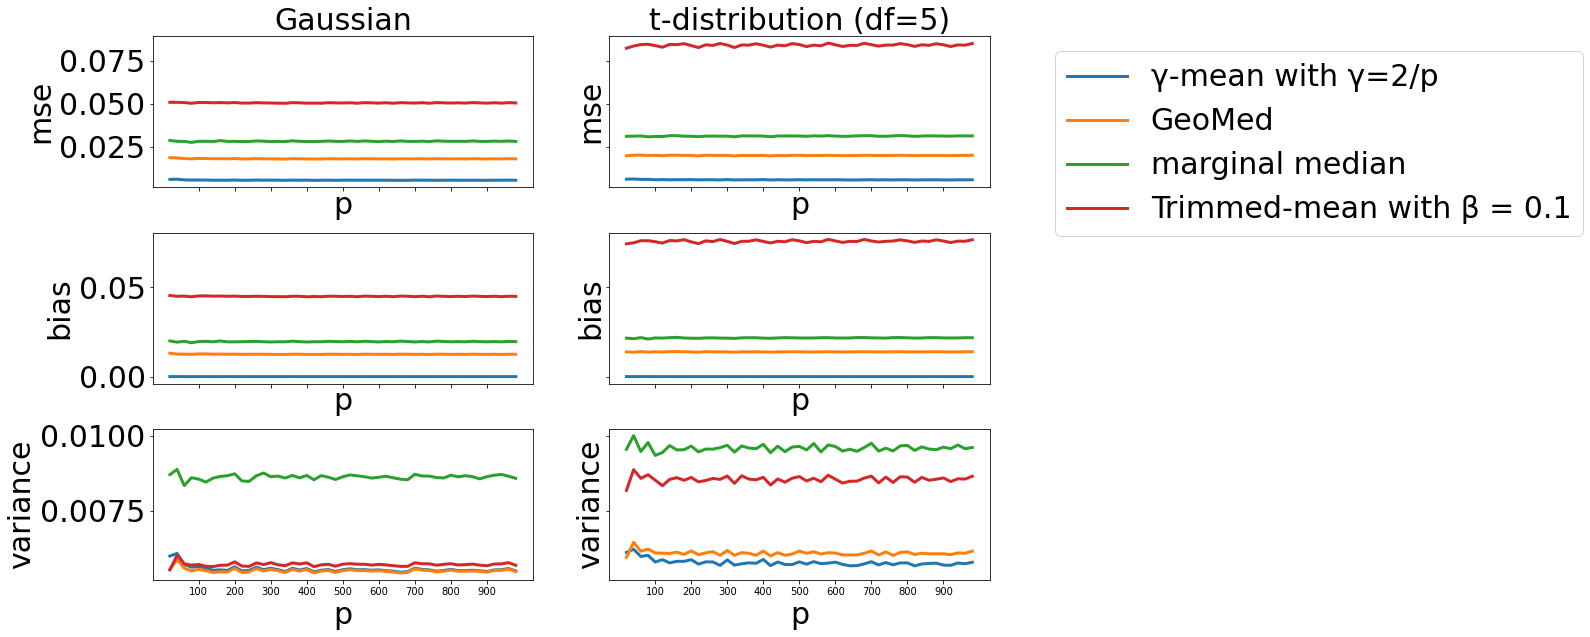

In [8]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs

ax1.set_title("Gaussian")
ax2.set_title('t-distribution (df=5)')
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in ["gamma","geo","median","trim"]:
      r = results[dist][method][i,:]
      ax.plot(p_range, r, label = method, linewidth = linewidth) 
      ax.set_xlabel('p')
      ax.set_xticks(p_range[np.arange(4,len(p_range),5)])
    ax.set_ylabel(metric.__name__)
ax = right[0]
  #method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=['\u03B3-mean with \u03B3=2/p', 'GeoMed', 'marginal median', 'Trimmed-mean with \u03B2 = {}'.format(beta)],
            loc='upper right',bbox_to_anchor=(2.6,1.0))
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario1_alpha_01_zoomin.png', format='png', bbox_inches='tight')

In [9]:
"""
Scenario 2
multiple experiments 

fix m=200 p=1000 
data from multi-normal distribution
when gamma=0.1
get station and low bias/p when alpha goes to 0.5
bias/p about 0.8 (senario 1: 0.01)
"""
seed = 2021
file_path = pathlib.Path("plot/scenario2.npz")
m = 200 #Total machines
simu_iter = 100 #number of experiments
#gamma = 0.005
beta = 0.1
# p: dimension 
p = 1000
alpha_range = np.arange(0.05,0.5,0.05)
metrics = [mse, bias, variance] #plot as below
"""
for i, metric in enumerate(metrics):
  plot results[dist][method][i_metrics,:] 
  ylab metric
""" 

dist_list = ["Gaussian", "T_dist"]  #for convenience if one day we want to add more generate dist
#declare a dictionary to map the generators to functions
dist2fun = {"Gaussian":Gaussian_gen, 
            "T_dist":partial(t_gen, df = 5)
            }

#for convenient if one day we want to add more aggregator
method_list = ["gamma","geo","median","trim","mean"]
labels=['\u03B3-mean with \u03B3=2/p', 'GeoMed', 'marginal median', 'Trimmed-mean with \u03B2 = {}'.format(beta), 'mean']

if file_path.is_file():
  print("load results file")
  results = np.load(file_path, allow_pickle = True)
  results = results['arr_0'].item()
else:
  #declare a dictionary, it is very convenient to add more object inside
  results=dict()

  #iterate all generators
  for dist in dist_list:
    #to restore results
    temp_result = dict()
    for method in method_list:
      temp_result[method] = np.zeros((len(metrics),len(alpha_range)))

    for alpha in alpha_range:
      b = int(m*alpha)
      mu = [0]*p
      mu_byz = [100]*p
      index = int(20*alpha - 1)
      gamma = 0.5/p
      #declare a dictionary to map the methods to functions
      method2fun = {"mean":partial(mean, weights = None),
                    "median":partial(median, weights = None),
                    "gamma":partial(gamma_mean, weights = None,compute = 'simple', gamma = gamma),
                    "geo":partial(geometric_median, weights = None),
                    "trim":partial(trimmed_mean, weights = None, beta = beta)
                    }
      
      gen_par = dist2fun[dist](mu, sigma=np.eye(p))
      byz_par = dist2fun[dist](mu_byz, sigma=np.eye(p))

      #to restore the estimation
      temp = dict()
      for method in method_list:
        temp[method]=[]
      #iterate many times
      for t in range(simu_iter):
        if int(t/20)==t/20:
          print("Iterate: {} for alpha: {} with data generated from {}".format(t,alpha,dist))
        np.random.seed(seed + 100*t + int(1000*alpha))
        input = np.concatenate((generate(p, m-b, gen_par), generate(p, b, byz_par)), axis = 0) if b>0 else generate(p, m, gen_par)
        for method in method_list:
          temp[ method ].append( method2fun[ method ]( input ) )
        #end repeating simulation for-loop
      for method in method_list:
        temp_result[method][:,index] = compute_result(temp[ method ], mu, metrics)
      #end alpha_range for-loop
    results [dist] = temp_result
    np.savez(file_path, results)
    #end dist_list for-loop     

load results file


/tmp/ipykernel_4056256/958467307.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


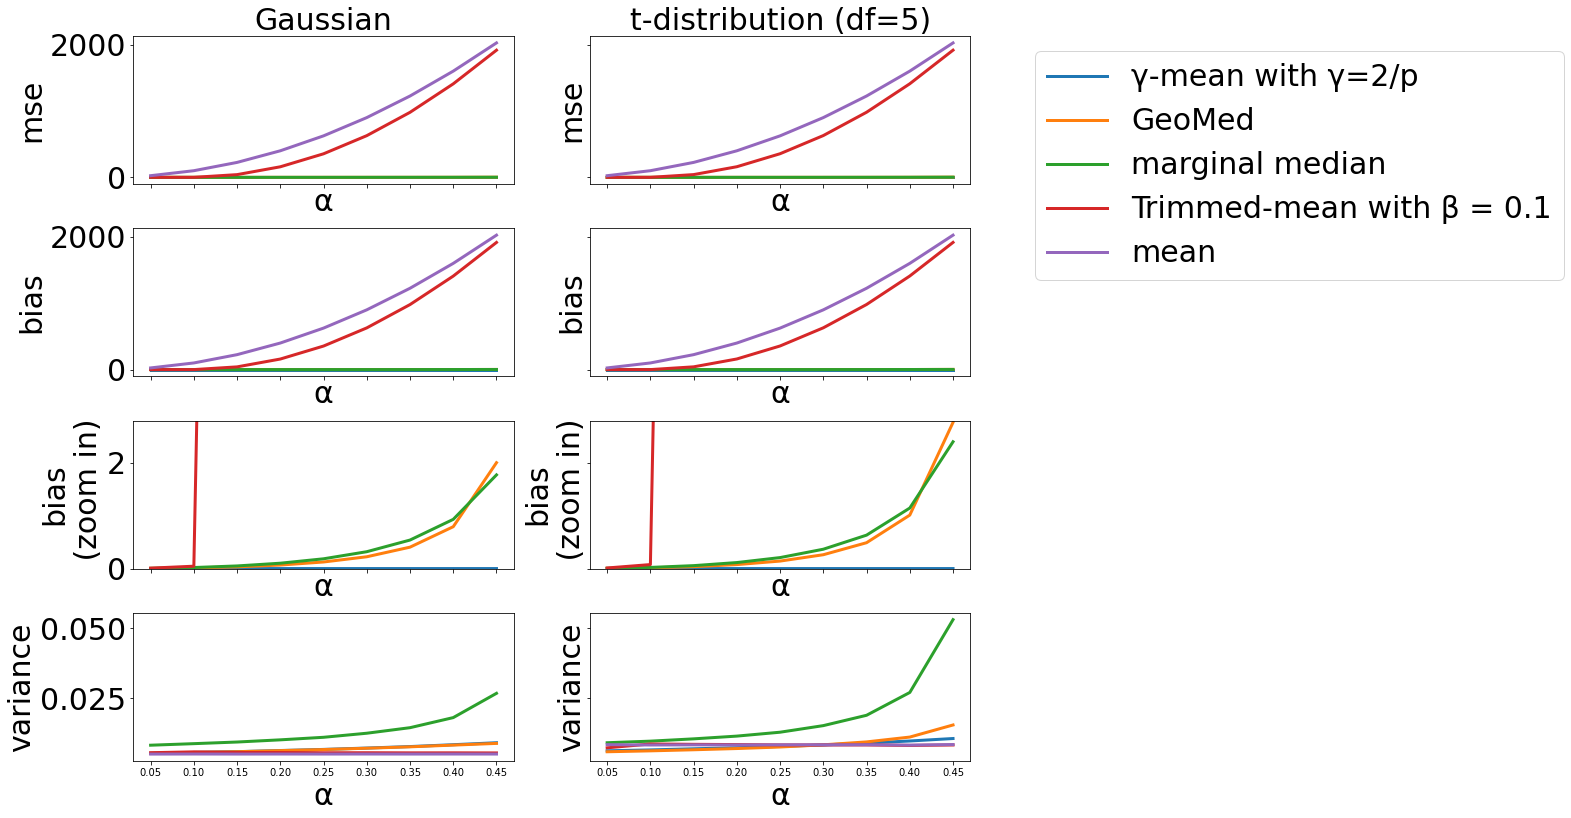

In [10]:
#plot the comparison of aggregators
fig, axs = plt.subplots(4, 2, figsize=(15, 13.33), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6), (ax7, ax8) = axs
ax1.set_title("Gaussian")
ax2.set_title('t-distribution (df=5)')
ax5.set_ylim(0,2.8)
right = [ax2, ax4, ax6, ax8]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    if i == 2:
      ax = axs[i+1][j]
    else:
      ax = axs[i][j]
    for method in method_list:
      r = results[dist][method][i,:]      
      ax.plot(alpha_range, r, label = method, linewidth = linewidth) 
      ax.set_xlabel('\u03B1') #alpha
      #ax.set_xticks(alpha_range[np.arange(4,len(alpha_range),5)])
    ax.set_ylabel(metric.__name__)

metric = metrics[1]
for j, dist in enumerate(dist_list):
  ax = axs[2][j]
  for method in method_list:
    r = results[dist][method][1,:]      
    ax.plot(alpha_range, r, label = method, linewidth = linewidth) 
    ax.set_xlabel('\u03B1') #alpha
    #ax.set_xticks(alpha_range[np.arange(4,len(alpha_range),5)])
  ax.set_ylabel(metric.__name__+'\n (zoom in)')
    
ax=right[0]
#method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=labels,
          loc='upper right',bbox_to_anchor=(2.6,1.0))
  
#plt.suptitle('Testing different aggregatros across \u03B1 ',fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario2_0.png', format='png', bbox_inches='tight')

/tmp/ipykernel_4056256/592573081.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


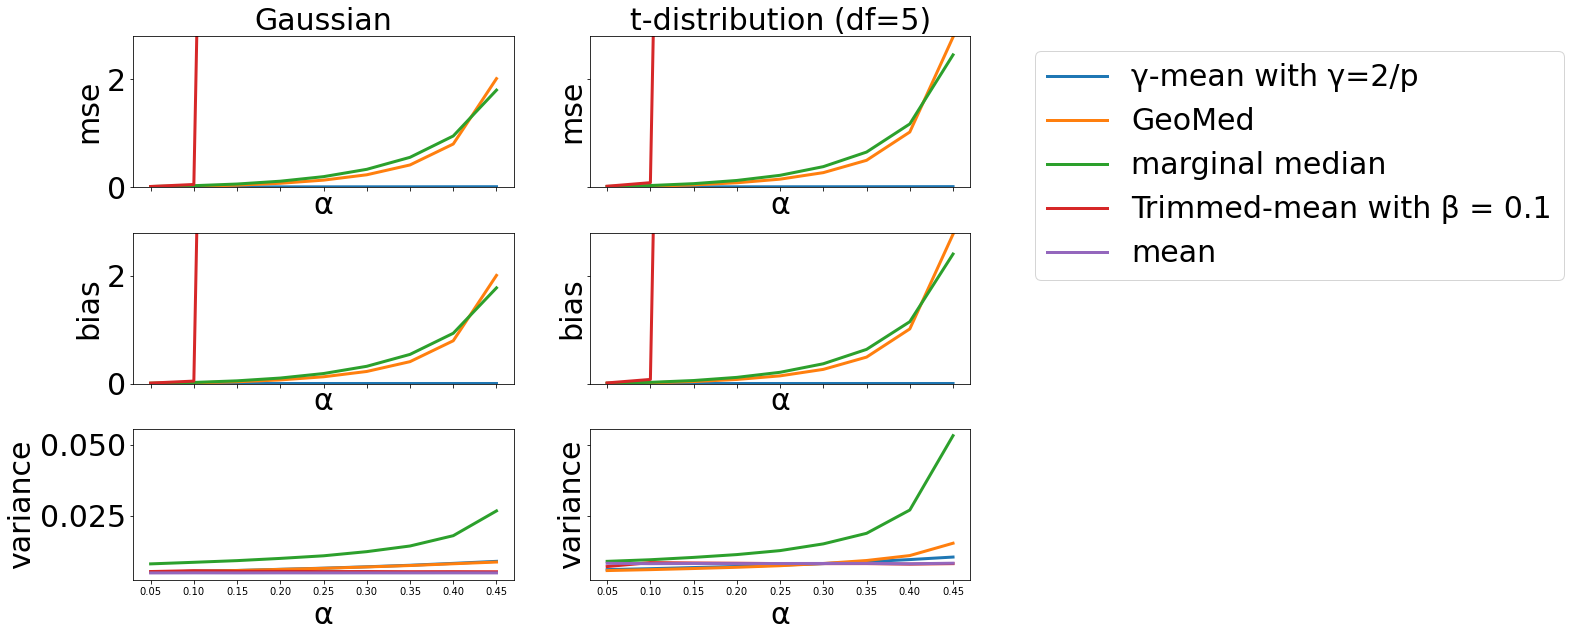

In [11]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs
ax1.set_title("Gaussian")
ax2.set_title('t-distribution (df=5)')
ax1.set_ylim(0,2.8)
ax3.set_ylim(0,2.8)
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    #for method in ["gamma","geo","median"]:
    for method in method_list:
      r = results[dist][method][i,:]      
      ax.plot(alpha_range, r, label = method, linewidth = linewidth) 
      ax.set_xlabel('\u03B1') #alpha
      #ax.set_xticks(alpha_range[np.arange(4,len(alpha_range),5)])
    ax.set_ylabel(metric.__name__)
ax=right[0]
#method_list is ["mean","median","gamma","geo","trim"] need to use the same order
#ax.legend(labels=['\u03B3-mean with \u03B3=2/p', 'GeoMed', 'marginal median', 'Trimmed-mean with \u03B2 = {}'.format(beta), 'mean'],
#          loc='upper right',bbox_to_anchor=(2.3,1.0))
ax.legend(labels=labels,
          loc='upper right',bbox_to_anchor=(2.6,1.0))

#plt.suptitle('Testing different aggregatros across \u03B1 ',fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario2_1.png', format='png', bbox_inches='tight')

/tmp/ipykernel_4056256/131805636.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


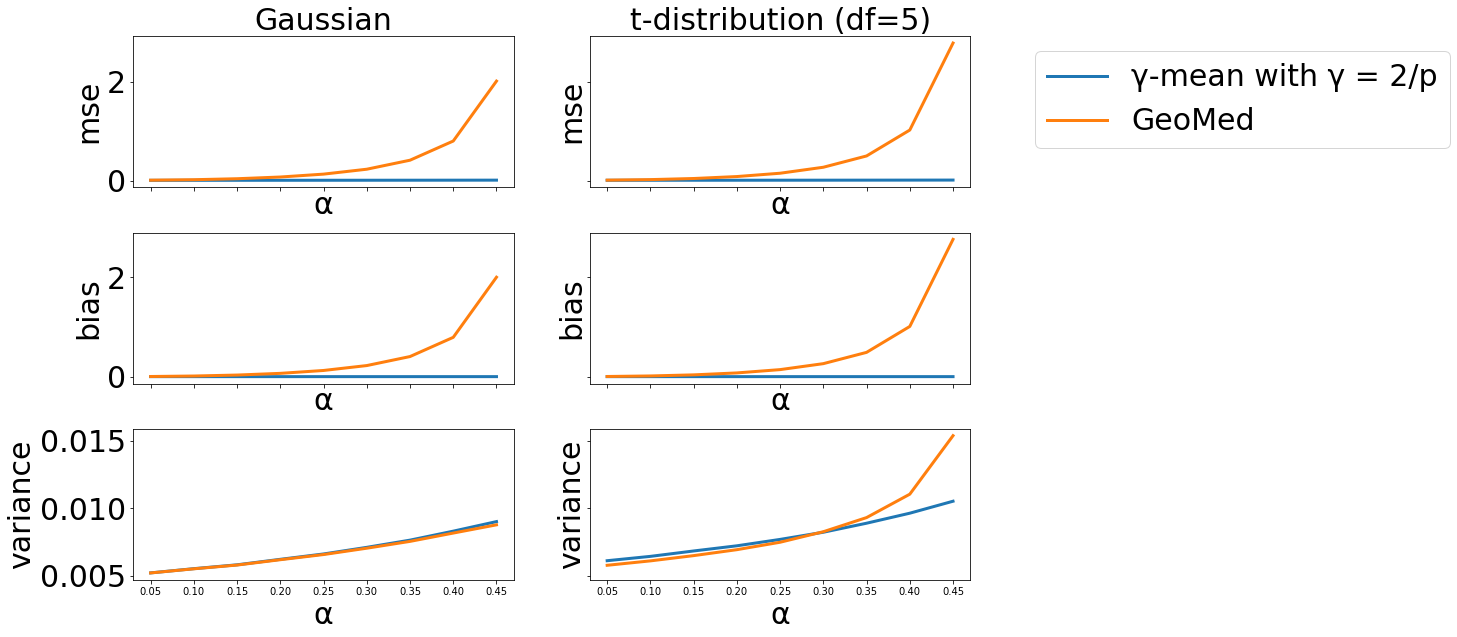

In [12]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs
ax1.set_title("Gaussian")
ax2.set_title('t-distribution (df=5)')
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in ["gamma","geo"]:
      r = results[dist][method][i,:]      
      ax.plot(alpha_range, r, label = method, linewidth = linewidth) 
      ax.set_xlabel('\u03B1') #alpha
      #ax.set_xticks(alpha_range[np.arange(4,len(alpha_range),5)])
    ax.set_ylabel(metric.__name__)
ax=right[0]
#method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=['\u03B3-mean with \u03B3 = 2/p', 'GeoMed'],
          loc='upper right',bbox_to_anchor=(2.3,1.0))
  
#plt.suptitle('Testing different aggregatros across \u03B1 ',fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario2_2.png', format='png', bbox_inches='tight')

Influence function: $(1+\gamma)^{\frac{p+2}{2}}e^{\frac{-\gamma}{2}(x_0-\mu)^\mathrm{T}\mathbf{\Sigma^{-1}}(x_0-\mu)}(x_0-\mu) $

Althogh theory indicates that $\gamma$-divergence reduces to KL-divergence as $\gamma\to 0$ , it seems like there is also a relation bewteen $p$ and $\gamma$, assume to be $\gamma=g(p)$, s.t. $\|\mu- \hat\mu\|<c$  
 
 Maybe $p\times\gamma<0.1$.  

In [13]:
"""    
experiment on gamma with p
scenario 3
"""
    
seed = 2021
file_path = pathlib.Path("plot/scenario3.npz")
m = 200 #Total machines
alpha = 0.1 #Byzantine fraction
simu_iter = 100 #number of experiments
beta = 0.1
# p: dimension 
p_range = np.arange(20,1000,20)

metrics = [mse, bias, variance] #plot as below

"""
for i, metric in enumerate(metrics):
  plot results[dist][method][i_metrics,:] 
  ylab metric
""" 

dist_list = ["Gaussian", "T_dist"]  #for convenience if one day we want to add more generate dist
#declare a dictionary to map the generators to functions
dist2fun = {"Gaussian":Gaussian_gen, 
            "T_dist":partial(t_gen, df = 5)
            }

#for convenient if one day we want to add more aggregator
method_list = ["gamma_0.5/p","gamma_1/p","gamma_2/p","gamma_3/p","gamma_4/p"]

if file_path.is_file():
  print("load results file")
  results = np.load(file_path, allow_pickle = True)
  results = results['arr_0'].item()
else:
  #declare a dictionary, it is very convenient to add more object inside
  results=dict()

  #iterate all generators
  for dist in dist_list:
    #to restore results
    temp_result = dict()
    for method in method_list:
      temp_result[method] = np.zeros((len(metrics),len(p_range)))

    for p in p_range:
      b = int(m*alpha)
      mu = [0]*p
      mu_byz = [100]*p
      index = int((p / 20) - 1)
      gamma = [0.5/p, 1/p, 2/p, 3/p, 4/p]
      #declare a dictionary to map the methods to functions
      #method2fun = {"gamma_0.5/p":partial(gamma_mean, weights = None, compute = 'simple', gamma = gamma[0]),
      #              "gamma_1/p":partial(gamma_mean, weights = None, compute = 'simple',  gamma = gamma[1]),
      #              "gamma_2/p":partial(gamma_mean, weights = None, compute = 'simple', gamma = gamma[2]),
      #              "gamma_3/p":partial(gamma_mean, weights = None, compute = 'simple', gamma = gamma[3]),
      #              "gamma_4/p":partial(gamma_mean, weights = None, compute = 'simple', gamma = gamma[4])
      #              }
      method2fun = {"gamma_0.5/p":partial(gamma_mean, weights = None, compute = '1D', gamma = gamma[0]),
                    "gamma_1/p":partial(gamma_mean, weights = None, compute = '1D',  gamma = gamma[1]),
                    "gamma_2/p":partial(gamma_mean, weights = None, compute = '1D', gamma = gamma[2]),
                    "gamma_3/p":partial(gamma_mean, weights = None, compute = '1D', gamma = gamma[3]),
                    "gamma_4/p":partial(gamma_mean, weights = None, compute = '1D', gamma = gamma[4])
                    }
      
      gen_par = dist2fun[dist](mu, sigma=np.eye(p))
      byz_par = dist2fun[dist](mu_byz, sigma=np.eye(p))

      #to restore the estimation
      temp = dict()
      for method in method_list:
        temp[method]=[]
      #iterate many times
      for t in range(simu_iter):
        if int(p/20)==p/20 and int(t/20)==t/20:
          print("Iterate: {} for dimension: {} with data generated from {}".format(t,p,dist))
        np.random.seed(seed + 100*t + p)
        input = np.concatenate((generate(p, m-b, gen_par), generate(p, b, byz_par)), axis = 0) if b>0 else generate(p, m, gen_par)
        for method in method_list:
          temp[ method ].append( method2fun[ method ]( input ) )
        #end repeating simulation for-loop
      for method in method_list:
        temp_result[method][:,index] = compute_result(temp[ method ], mu, metrics)
      #end alpha_range for-loop
    results [dist] = temp_result
    np.savez(file_path, results)
    #end dist_list for-loop

load results file


/tmp/ipykernel_4056256/595713873.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


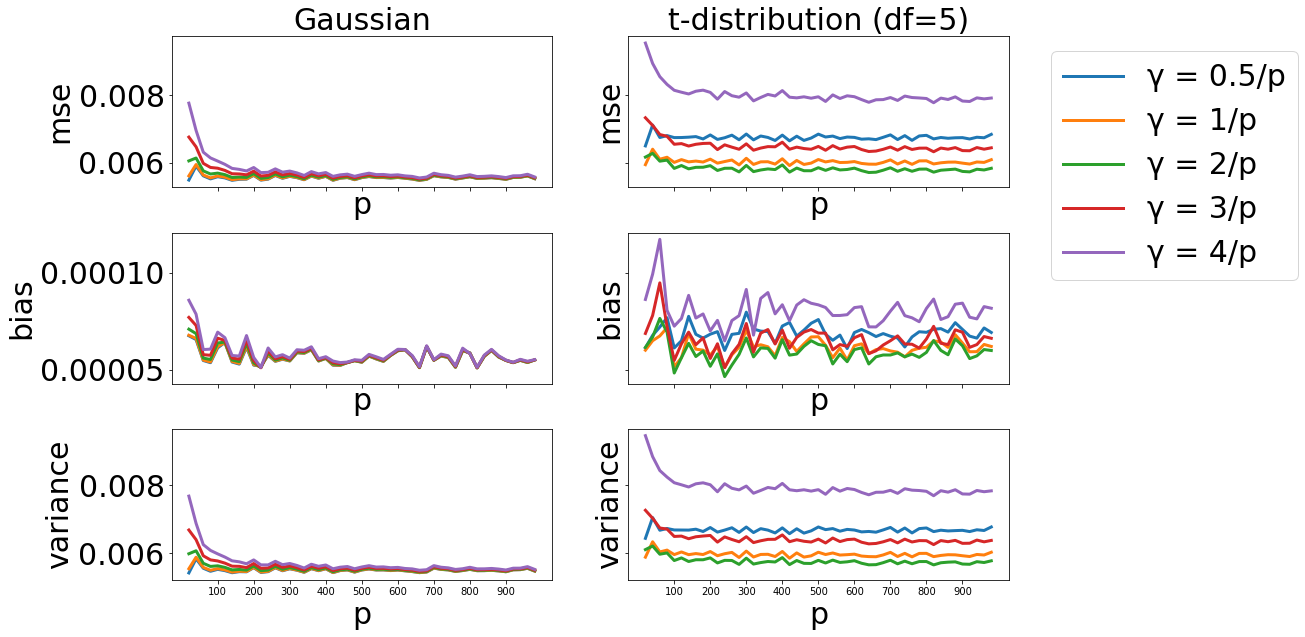

In [14]:
#plot comparison of different gammas
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs
ax1.set_title("Gaussian")
ax2.set_title('t-distribution (df=5)')
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in method_list:
      r = results[dist][method][i,:]      
      ax.plot(p_range, r, label = method, linewidth = linewidth)
      ax.set_xlabel('p')
      ax.set_xticks(p_range[np.arange(4,len(p_range),5)])
    ax.set_ylabel(metric.__name__)

ax = right[0]
  #method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=['\u03B3 = 0.5/p', '\u03B3 = 1/p', '\u03B3 = 2/p','\u03B3 = 3/p', '\u03B3 = 4/p']
          ,loc='upper right',bbox_to_anchor=(1.8,1.0))
#plt.suptitle('Testing different \u03B3 across dimension p, \u03B1 = {}'.format(alpha),fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario3_alpha_01.png', format='png', bbox_inches='tight')

In [15]:
"""
fix m=200 alpha=0.1
data from T distribution(df=3)

test gamma_mean simple and 1D
"""
#set seed
seed = 2021
file_path = pathlib.Path("plot/scenario4.npz")
m = 200 #Total machines
alpha = 0.1
b = int(m*alpha) #Byzantine machines
simu_iter = 100 #number of experiments

# p: dimension 
p_range = np.arange(20,1000,20)

metrics = [mse, bias, variance] #plot as below
"""
for i, metric in enumerate(metrics):
  plot results[dist][method][i_metrics,:] 
  ylab metric
""" 

dist_list = ["Gaussian", "T_dist"]  #for convenience if one day we want to add more generate dist
#declare a dictionary to map the generators to functions
dist2fun = {"Gaussian":Gaussian_gen, 
            "T_dist":partial(t_gen, df = 5)
            }

#for convenient if one day we want to add more aggregator
method_list = ["gamma_1D","gamma_simple"]

if file_path.is_file():
  print("load results file")
  results = np.load(file_path, allow_pickle = True)
  results = results['arr_0'].item()
else:
  #declare a dictionary, it is very convenient to add more object inside
  results=dict()

  #iterate all generators
  for dist in dist_list:
    #to restore results
    temp_result = {"gamma_1D":None,
                  "gamma_simple":None,}
    for method in method_list:
      temp_result[method] = np.zeros((len(metrics),len(p_range)))

    for p in p_range:
      mu = [0]*p
      mu_byz = [100]*p
      index = int((p / 20) - 1)
      gamma = 2/p
      #declare a dictionary to map the methods to functions
      method2fun = {"gamma_1D":partial(gamma_mean, weights = None, compute = "1D", gamma = gamma),
                    "gamma_simple":partial(gamma_mean, weights = None, compute = "simple", gamma = gamma, dim_red = True)
                    }
      gen_par = dist2fun[dist](mu, sigma=np.eye(p))
      byz_par = dist2fun[dist](mu_byz, sigma=np.eye(p))

      #to restore the estimation
      temp = dict()
      for method in method_list:
        temp[method]=[]
      #iterate many times
      for t in range(simu_iter):
        if int(p/20)==p/20 and int(t/20)==t/20:
          print("Iterate: {} for dimension: {} with data generated from {}".format(t,p,dist))
        np.random.seed(seed + 100*t + p)
        input = np.concatenate((generate(p, m-b, gen_par), generate(p, b, byz_par)), axis = 0) if b>0 else generate(p, m, gen_par)
        for method in method_list:
          temp[ method ].append( method2fun[ method ]( input ) )
        #end repeating simulation for-loop
      for method in method_list:
        temp_result[method][:,index] = compute_result(temp[ method ], mu, metrics)
      #end p_range for-loop
    results [dist] = temp_result
    np.savez(file_path, results)
    #end dist_list for-loop

load results file


/tmp/ipykernel_4056256/2986005226.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


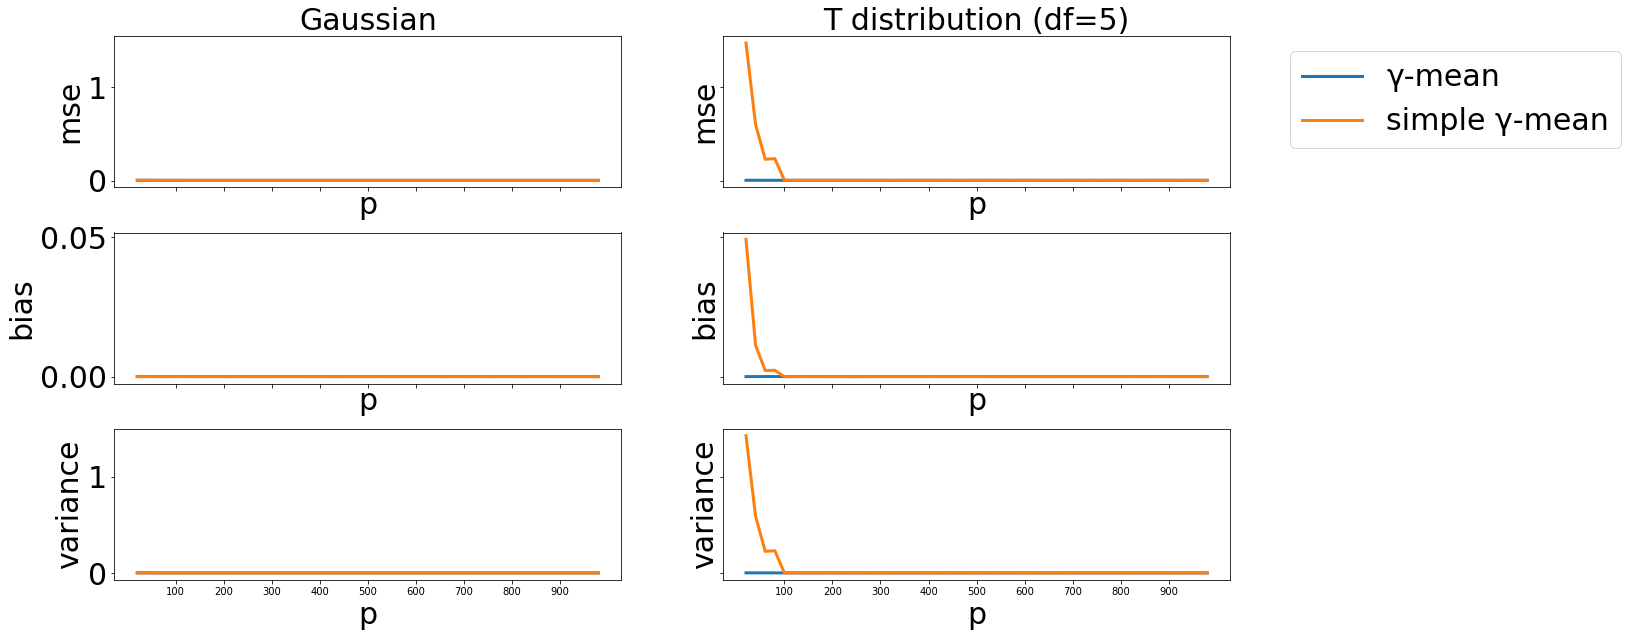

In [16]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs

ax1.set_title("Gaussian")
ax2.set_title('T distribution (df=5)')
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in method_list:
      r = results[dist][method][i,:]
      ax.plot(p_range, r, label = method, linewidth = linewidth) 
      ax.set_xlabel('p')
      ax.set_xticks(p_range[np.arange(4,len(p_range),5)])
    ax.set_ylabel(metric.__name__)
ax = right[0]
  #method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=['\u03B3-mean', 'simple \u03B3-mean'],
          loc='upper right',bbox_to_anchor=(1.8,1.0))
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario4.png', format='png', bbox_inches='tight')

/tmp/ipykernel_4056256/1925471614.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


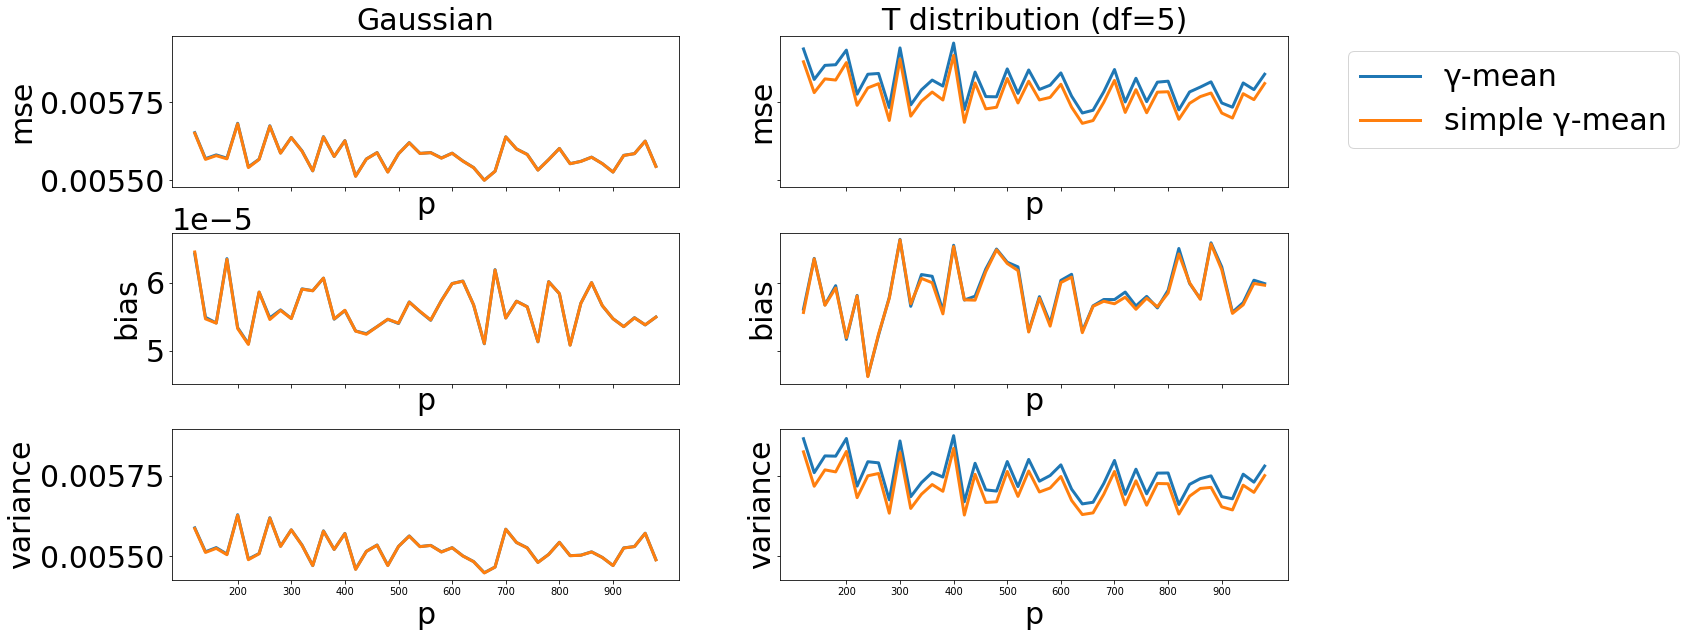

In [17]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs

ax1.set_title("Gaussian")
ax2.set_title('T distribution (df=5)')
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in method_list:
      r = results[dist][method][i,5:]
      ax.plot(p_range[5:], r, label = method, linewidth = linewidth) 
      ax.set_xlabel('p')
      ax.set_xticks(p_range[np.arange(9,len(p_range),5)])
    ax.set_ylabel(metric.__name__)
ax = right[0]
  #method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=['\u03B3-mean', 'simple \u03B3-mean'],
          loc='upper right',bbox_to_anchor=(1.8,1.0))
fig.tight_layout()
plt.show()

fig.savefig('plot/scenario4_p_above_100.png', format='png', bbox_inches='tight')

In [18]:
"""
fix m=200 alpha=0.1
data from T distribution(df=3)

test gamma_mean simple and 1D
"""
#set seed
seed = 2021
gamma = 0.05
file_path = pathlib.Path("plot/scenario4_gamma_{}.npz".format(str(gamma).replace(".","_")))
m = 200 #Total machines
alpha = 0.1
b = int(m*alpha) #Byzantine machines
simu_iter = 100 #number of experiments

# p: dimension 
p_range = np.arange(20,1000,20)

metrics = [mse, bias, variance] #plot as below
"""
for i, metric in enumerate(metrics):
  plot results[dist][method][i_metrics,:] 
  ylab metric
""" 

dist_list = ["Gaussian", "T_dist"]  #for convenience if one day we want to add more generate dist
#declare a dictionary to map the generators to functions
dist2fun = {"Gaussian":Gaussian_gen, 
            "T_dist":partial(t_gen, df = 5)
            }

#for convenient if one day we want to add more aggregator
method_list = ["gamma_1D","gamma_simple"]

if file_path.is_file():
  print("load results file")
  results = np.load(file_path, allow_pickle = True)
  results = results['arr_0'].item()
else:
  #declare a dictionary, it is very convenient to add more object inside
  results=dict()

  #iterate all generators
  for dist in dist_list:
    #to restore results
    temp_result = {"gamma_1D":None,
                  "gamma_simple":None,}
    for method in method_list:
      temp_result[method] = np.zeros((len(metrics),len(p_range)))

    for p in p_range:
      mu = [0]*p
      mu_byz = [100]*p
      index = int((p / 20) - 1)
      #declare a dictionary to map the methods to functions
      method2fun = {"gamma_1D":partial(gamma_mean, weights = None, compute = "1D", gamma = gamma),
                    "gamma_simple":partial(gamma_mean, weights = None, compute = "simple", gamma = gamma, dim_red = True)
                    }
      gen_par = dist2fun[dist](mu, sigma=np.eye(p))
      byz_par = dist2fun[dist](mu_byz, sigma=np.eye(p))

      #to restore the estimation
      temp = dict()
      for method in method_list:
        temp[method]=[]
      #iterate many times
      for t in range(simu_iter):
        if int(p/20)==p/20 and int(t/20)==t/20:
          print("Iterate: {} for dimension: {} with data generated from {}".format(t,p,dist))
        np.random.seed(seed + 100*t + p)
        input = np.concatenate((generate(p, m-b, gen_par), generate(p, b, byz_par)), axis = 0) if b>0 else generate(p, m, gen_par)
        for method in method_list:
          temp[ method ].append( method2fun[ method ]( input ) )
        #end repeating simulation for-loop
      for method in method_list:
        temp_result[method][:,index] = compute_result(temp[ method ], mu, metrics)
      #end p_range for-loop
    results [dist] = temp_result
    np.savez(file_path, results)
    #end dist_list for-loop

load results file


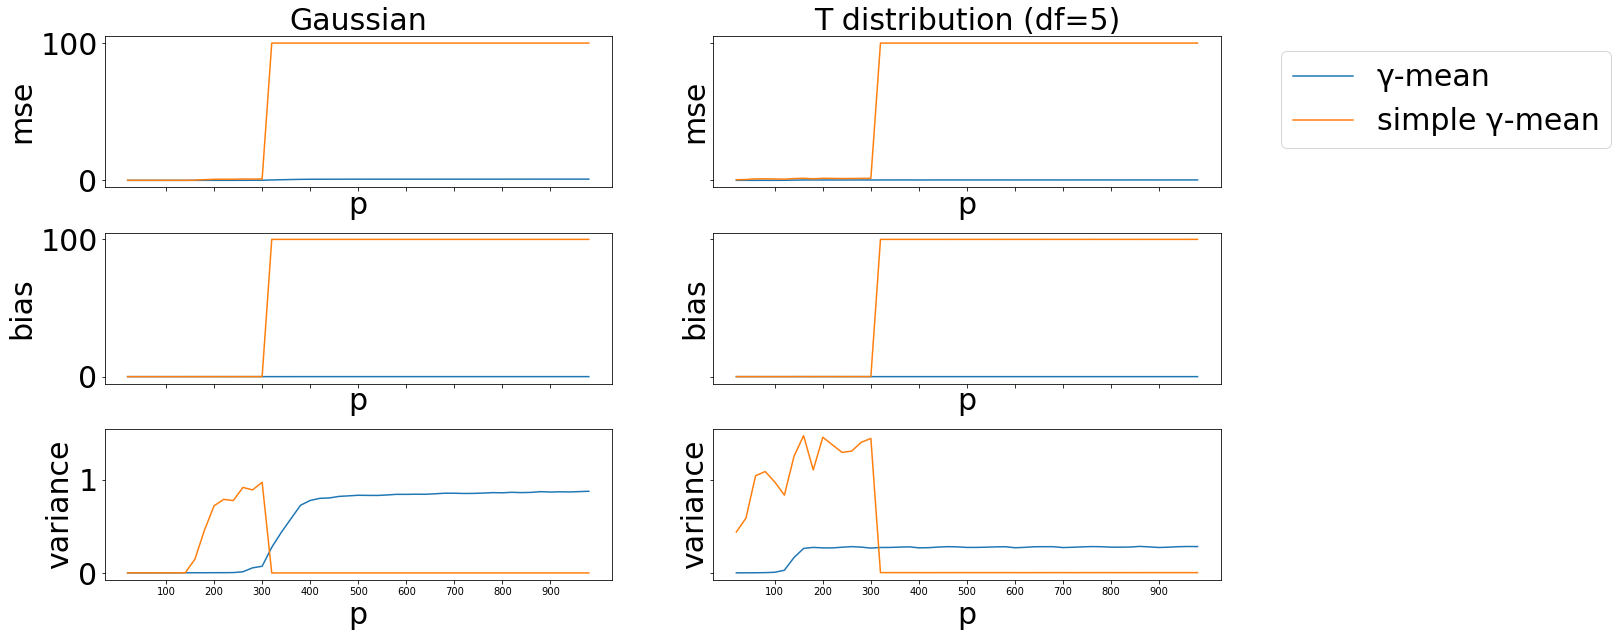

In [19]:
#plot the comparison of aggregators
fig, axs = plt.subplots(3, 2, figsize=(20, 10), sharex=True, sharey='row',  gridspec_kw={'hspace': 0.3, 'wspace': 0.2})
(ax1, ax2),  (ax3, ax4), (ax5, ax6)= axs

ax1.set_title("Gaussian")
ax2.set_title('T distribution (df=5)')
right = [ax2, ax4, ax6]

for i, metric in enumerate(metrics):
  for j, dist in enumerate(dist_list):
    ax = axs[i][j]
    for method in method_list:
      r = results[dist][method][i,:]
      ax.plot(p_range, r, label = method) 
      ax.set_xlabel('p')
      ax.set_xticks(p_range[np.arange(4,len(p_range),5)])
    ax.set_ylabel(metric.__name__)
    
ax = right[0]
#method_list is ["mean","median","gamma","geo","trim"] need to use the same order
ax.legend(labels=['\u03B3-mean', 'simple \u03B3-mean'],
          loc='upper right',bbox_to_anchor=(1.8,1.0))
plt.show()

fig.savefig('plot/scenario4_gamma_{}.png'.format(str(gamma).replace(".","_")), format='png', bbox_inches='tight')